In [1]:
import numpy as np
import sys
from scipy.interpolate import interp1d

sys.path.append('../qslam/')
from visualiserisk import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from qslamdesignparams import GRIDDICT

## Archive Data Analysis

This figure is based on data from Feb 2019. The codebase has changed since then but these changes have been largely restricted to the controller and the tuning procedure; hence NMQA is likely to be under-performing the datasets below. 

We want to briefly re-state previous analysis on how increasing then number of qubits per iteration  for a true (sqaure) field impacts NMQA performance relative to Naive. 

The local folder path to the project is:

In [2]:
ls ../Archive/noisy_sim_data_2/

2DNOV2018_selected.py                  NSL_Full_Figures - Height.ipynb
data/                                  NSL_Risk_Matrix_Generator.ipynb
figs/                                  NSL_Risk_Matrix_Generator_Plots.ipynb
job_0.pbs                              sample_code_figs.ipynb
job_1.pbs                              sample_code_inv_functions.ipynb
N2D_Risk_Matrix_Generator.ipynb        sample_code_riskanalysis.ipynb
NSL_Full_Figures - Floor.ipynb         test_script.py
NSL_Full_Figures - Height-Copy1.ipynb


Previously generated figures can be found as a .ipynb notebook at "NSL_Full_Figures - Floor.ipynb " and "NSL_Risk_Matrix_Generator_Plots.ipynb".

In particular, "NSL_Risk_Matrix_Generator_Plots.ipynb" provides a Noiseless case, for prevar =1 (corresponding to a ratio of low to high field approx 0.4) varying results of Avg. SSIM vs. T (total iterations) by panels left to right from msmts per iteration as 1, 2, 3,4 ,5, 6, 7,8 ,9, 10, 15, 20, 25, 50.

This is the particular subset of the full project that we re-plot here.  

We set the local filepath as:

In [3]:
archive_project_path = '../Archive/noisy_sim_data_2/'

### [OLD] Parameter Regimes

The set of parameters are given in the dictionary format, LOOPS_DICT, and used for analysis via ParamUpdater. 

In [4]:
meta_truth_floor_scan = [0.2, 0.4, 0.6, 0.8, 1.0]

meta_max_iter_scan = [ 5, 10, 15, 20, 25, 50, 75, 100, 125, 250]

noiseclasses = ['noiseless'] + ['alwaysdark', 'spnoise']*4
noisestrengths = [0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.5, 0.5]*2 # shouldnt be a 2 but hopefully doesnt matter
meta_noisevar_scan = zip(noiseclasses, noisestrengths)

lowscan = np.asarray([0.2]*5)*np.pi
highscan = np.asarray([0.2, 0.4, 0.6, 0.8, 1.0])*np.pi
truth_step_scan = zip(lowscan, highscan)


lambda1 = [0.99, 0.956, 0.922, 0.888, 0.854, 0.820, 0.786, 0.752, 0.718, 0.684, 0.65]
lambda2 = [0.977, 0.9752, 0.9734, 0.9716, 0.9698, 0.968, 0.9662, 0.9644, 0.9626, 0.9608, 0.959]
lambda_scan = zip(lambda1, lambda2)
msmt_per_qubit_scan = [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]

msmt_per_qubit_scan = [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]


LOOPS_DICT = {"meta_truth_floor_scan": meta_truth_floor_scan,
              "meta_max_iter_scan":meta_max_iter_scan, 
              "meta_noisevar_scan": meta_noisevar_scan,
              "truth_step_scan": truth_step_scan,
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)


### Select only the relevant subsets.

In [5]:
weightratioslist = []
msmtperqubitlist = []

for prefix in ['NSL_tfloor']:
    
    for idx_noise_var in [0]:
        
        idx_var_dict =1 

        regime_ID = prefix + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
        datafile = archive_project_path + 'data/'+'RISK_' + regime_ID +'.npz'

# Data variables
max_msmtvar = len(ParamUpdater.meta_max_iter_scan)
max_var = len(ParamUpdater.msmt_per_qubit_scan)

In [6]:
print(datafile)
print "dim (T): ", max_msmtvar
print "dim (msmts per iteration): ", max_var

../Archive/noisy_sim_data_2/data/RISK_NSL_tfloor_n_0_vset_1.npz
dim (T):  10
dim (msmts per iteration):  11


In [7]:
archive_data_cube = np.load(datafile)
print(archive_data_cube.files)
full_data_matrix = archive_data_cube["full_data_matrix"]

'''
Dimensions of full_data_matrix:

full_data_matrix.shape[0]: Dims of meta_truth_floor_scan (low to high field ratio). We want index 1. 
full_data_matrix.shape[1]: Dims of meta_max_iter_scan (T). We want all values to be plotted along the X axis
full_data_matrix.shape[2]: Dims of msmt_per_qubit_scan. We want to select 3-4 key values 
full_data_matrix.shape[3]: Dims of algorithm type, i.e. NMQA [index 0] or Naive [index 1].
full_data_matrix.shape[4]: Dims of error metric, i.e. nRMS [index 2] or SSIM [index 3]; other indicies defunct.
'''
full_data_matrix.shape

['full_data_matrix']


(5, 10, 11, 2, 4)

In [8]:
select_idx_prevar = 1
select_idx_var = [1, 7, 10] # for 2, 10 and 50 msmts per t
select_idx_metric = 3

### Linear Interpolation Fit

In [9]:
START = 0.01
END = 0.6
FIT_TYPE = 'linfit'
x_space = np.linspace(START, END, 601)

('Number of measurements:', 2)
601
601


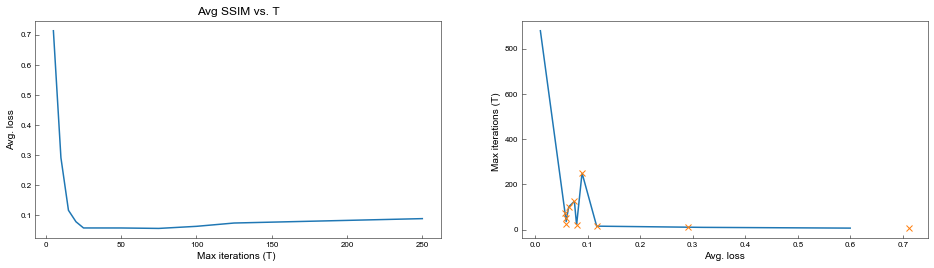

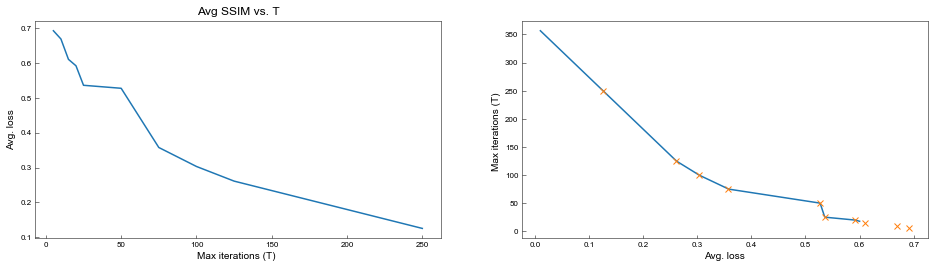

('Number of measurements:', 15)
601
601


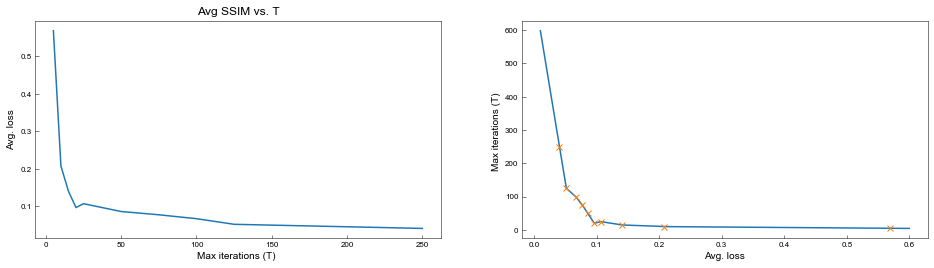

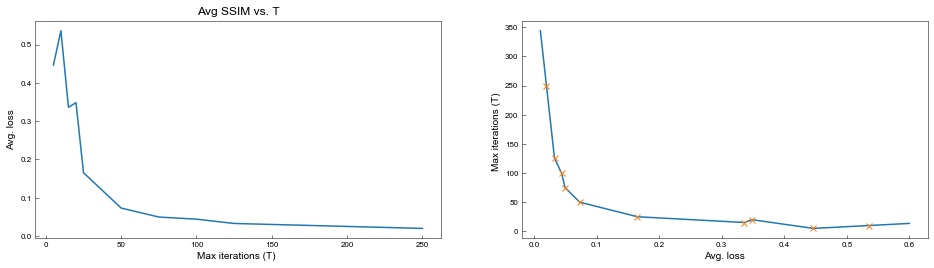

('Number of measurements:', 50)
601
601


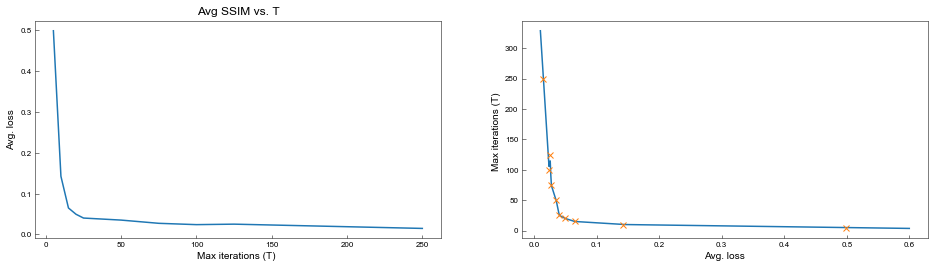

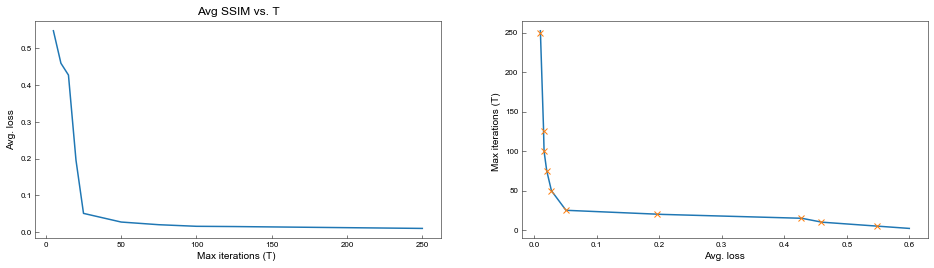

In [10]:
if FIT_TYPE == 'linfit':

    curve_fit_data = np.empty((len(select_idx_var), 2, len(x_space))) # alwasy 601 entries
    
    for idx_case in range(len(select_idx_var)):
        
        set_idx_var = select_idx_var[idx_case]
        
        print("Number of measurements:", msmt_per_qubit_scan[set_idx_var])

        for idx_dataset in range(2):
            
            mean_vals = full_data_matrix[select_idx_prevar, :, set_idx_var, idx_dataset, select_idx_metric]

            fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16,4))

            # Plot expected loss for each case:

            ax.plot(meta_max_iter_scan,  mean_vals)
            ax.set(title='Avg SSIM vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')

            # Plot loss data and optimise power law fit

            x_vals = mean_vals
            y_vals = meta_max_iter_scan

            if FIT_TYPE == 'linfit':
                interpolate_func = interp1d(x_vals, y_vals, fill_value='extrapolate')

            interpolated_values = interpolate_func(x_space)

            interpolated_values[interpolated_values<0] = 2.
                
            curve_fit_data[idx_case, idx_dataset, : ] = interpolated_values
            print(len(interpolated_values))

            ax2.plot(x_space, interpolated_values)
            ax2.plot(x_vals, y_vals, 'x')
            ax2.set(ylabel='Max iterations (T) ', xlabel='Avg. loss')

        plt.show()




('Ratio drops below unity for score:', 0.041466666666666666)
('Max ratio', 17.191199478337758, 'for score ', 0.11718333333333332)
('Ratio at Avg. SSIM = 0.1: ', 2.2089289157458296)


('Ratio drops below unity for score:', 0.08669999999999999)
('Max ratio', 2.9722739519688863, 'for score ', 0.6)
('Ratio at Avg. SSIM = 0.1: ', 1.731160438661807)


('Ratio drops below unity for score:', 0.03655)
('Max ratio', 2.495179907382256, 'for score ', 0.4269333333333333)
('Ratio at Avg. SSIM = 0.1: ', 1.8584784454317549)


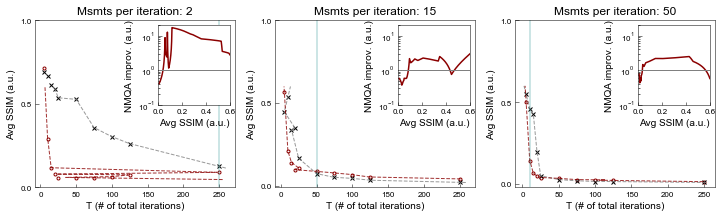

In [104]:
loss_label = ['SSIM']
case_titles = [str(msmt_per_qubit_scan[select_idx_var[idx]]) for idx in range(len(select_idx_var))]
XLIMMAX = 260
GRIDSIZE = 25.
PER_QUBIT_THRESHOLD = 20.
TOTAL_MSMTS_AT_THRESHOLD = GRIDSIZE * PER_QUBIT_THRESHOLD

if FIT_TYPE == 'linfit':

    fig, axes_ = plt.subplots(1, 3, figsize=(cm2inch(30.95), cm2inch(7.8)))
    axes = np.empty_like(axes_)
    axes = np.vstack([axes, axes])


    for idx_case in range(len(select_idx_var)):

        idx_dataset_nmqa = 0
        idx_dataset_naive = 1
        set_idx_var = select_idx_var[idx_case]

        axes[0, idx_case] = axes_[idx_case]
        axes[1, idx_case] = inset_axes(axes[0, idx_case], width=1, height=1.1)#, loc=4)

        naive_vals = curve_fit_data[idx_case, idx_dataset_naive, : ]
        nmqa_vals = curve_fit_data[idx_case, idx_dataset_nmqa, : ]
        naive_mask = naive_vals<=XLIMMAX
        nmqa_mask = nmqa_vals<=XLIMMAX


        # compute ratio
        mean = naive_vals / nmqa_vals
        
        print 
        print
        below_unity_arg = len(mean[0:200][mean[0:200]<1.0]) - 1
        print("Ratio drops below unity for score:", x_space[0:100][below_unity_arg])
        print("Max ratio", np.max(mean), "for score ", x_space[np.argmax(mean)])

        condition_match = np.argwhere(np.round(x_space, 2)==0.1)
        # print condition_match
        at_point_1 = int(condition_match[-1])
        print("Ratio at Avg. SSIM = 0.1: ", mean[at_point_1] )

        axes[0, idx_case].set_title("Msmts per iteration: " + str(case_titles[idx_case]))

        axes[0, idx_case].plot(meta_max_iter_scan, 
                               full_data_matrix[select_idx_prevar, :, set_idx_var, idx_dataset_nmqa, select_idx_metric],
                               'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
        axes[0, idx_case].plot(meta_max_iter_scan, 
                               full_data_matrix[select_idx_prevar, :, set_idx_var, idx_dataset_naive, select_idx_metric],
                               'x', ms=3.5, c='k', label='Naive')

        axes[0, idx_case].plot(naive_vals[naive_mask], x_space[naive_mask], '--', lw=1.0,
                               alpha=0.8, c='gray', label='Naive Fit')
        axes[0, idx_case].plot(nmqa_vals[nmqa_mask], x_space[nmqa_mask], '--', lw=1.0,
                               alpha=0.8, c='darkred', label='NMQA Fit')

        axes[0, idx_case].yaxis.set_ticks(np.arange(0., 1.1, 0.5))
#         axes[0, idx_case].set_ylim([0., 1.])
#         axes[0, idx_case].set_xlim([0, 260])


        MAINCOLOR='darkred'
        MAINLABEL='Numerically Tuned'
        axes[1, idx_case].plot(x_space, mean, '-', c=MAINCOLOR, lw=1.5,
                              label=r'$\lambda_{1,2}$ ' + MAINLABEL)
        axes[1, idx_case].axhline(y=1.0, lw=1.0, c='gray', ls='-')
        axes[1, idx_case].set_yscale('log') 
        axes[1, idx_case].set_ylim([10**-1, 2*10.**1])
        axes[1, idx_case].set_xlim([0., END])        

        axes[0, idx_case].set_xlabel('T (# of total iterations)')
        axes[1, idx_case].set_xlabel(r'Avg SSIM (a.u.)')
        axes[0, idx_case].set_ylabel(r'Avg SSIM (a.u.)')
        axes[1, idx_case].set_ylabel('NMQA improv. (a.u.)')
        

        total_msmts_budget = msmt_per_qubit_scan[set_idx_var]* np.asarray(meta_max_iter_scan)
        vertical_line_at_threshold = np.argwhere(total_msmts_budget>=TOTAL_MSMTS_AT_THRESHOLD)
        axes[0, idx_case].axvline(x= meta_max_iter_scan[int(vertical_line_at_threshold[0])],
                                 lw=2.0, color='teal', alpha=0.2)


    figdatafile =  'Msmts_per_Qubit_SSIM'+'_'+ str(select_idx_metric)+'_opt_'+ str(True) + '_' + FIT_TYPE
    plt.savefig('./FIGURES/Archive_Data' +figdatafile+'.svg', format='svg', dpi=900)
    plt.show()